# Bayesian Data Analysis

This notebook provides a very simple example of Bayesian parameter estimation using the Beta-Binomial model. Both analytical and simulation-based results are presented.

## Approaches to Data Analysis

><i>"All models are wrong, but some are useful"</i> -- George Box

### 1. Exploratory
><p>Descriptive statistics without any probabilistic assumptions
><p>Examples include: Average, Median, Quantiles, Range, Variance, Minimum/Maximum, Histogram, and various other plots and charts

### 2. Frequentist
><p>Assumes a probability model with a fixed, deterministic parameter, $\theta$</p>
><p>$X \sim F(x;\theta)$</p>
><p>(quantities can be scalars or vectors)</p>

### 3. Bayesian
><p>Assumes a probability model with a random parameter that has its own model</p>
><p>$(X|\Theta=\theta) \sim F(x;\theta)$ called the "Likelihood Distribution"</p>
><p>$\Theta \sim G(\theta;\gamma)$ called the "Prior Distribution"</p>
><p>$\gamma$ is called a "hyperparameter" and is usually deterministic</p>

To make inferences about a model, Frequentist or Bayesian, it is necessary to estimate the parameter, $\theta$, (scalar or vector) of the model.

In the Frequentist case, the Maximum Likelihood Estimate (MLE) is typically derived. The MLE is a deterministic value.

In the Bayesian case, the conditional probability distribution (or density) of the parameter, given the observed data, is usually derived: $P(\Theta \mid X=x)$. It's called the <i>posterior</i> distribution/density.  Depending on the type of likelihood and prior, the derivation of the posterior might be intractable, so simulation is required, typically via a Markov Chain Monte Carlo (MCMC) algorithm.

## Beta-Binomial Example

This is probably one of the most often sited examples of Bayesian estimation. The posterior distribution can be computed analytically.  Also, the prior and posterior are from the same family of distributions, and so they are called <i>conjugate</i> distributions.

### The Data

Assume that we've conducted $n$ [binomial trials](https://en.wikipedia.org/wiki/Binomial_distribution) with an unknown probability of success, $\theta$, and that we've observed $k_{obs}$ successes:

In [2]:
n = 20  # Number of trials
k_obs = 6  # Number of observed successes in n trials

Frequentists can stop here:

In [3]:
print(f"The MLE estimate of theta is k_obs/n = {k_obs}/{n} = {k_obs/n}")

The MLE estimate of theta is k_obs/n = 6/20 = 0.3


Moving on...

### The Bayesian Beta-Binomial Model

#### Likelihood:
>Probabilistic model of the data
><p>$(K|\Theta=\theta) \sim Binomial_n(k;\theta) \equiv \binom{n}{k} \theta^k(1-\theta)^{n-k}$</p>

#### Prior:
>Probabilistic model of the likelihood model parameter
><p>$\Theta \sim Beta(\theta; \alpha, \beta) \equiv \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha - 1} (1-\theta)^{\beta - 1}$</p>
><p>For this example, assume $\Theta \sim Beta(1, 1)$, which is equivalent to the uniform distribution:
><p>$Beta(1,1) \equiv U(0,1)$</p>

#### Posterior
>Probabilistic model of the parameter(s), given the observed data
><p>According to Bayes Theorem, <b>Posterior $\propto$ Likelihood $\times$ Prior</b>
><p>So, after some algebraic manipulation we have,
><p>$(\Theta \mid K=k) \sim Beta(\theta; \alpha+k, \beta+n-k)$</p>

So, for the data provided above we have:
><p>$(\Theta \mid K=k_{obs}) \sim Beta(\theta; 1+k_{obs}, 1+n-k_{obs})$</p>

In [4]:
posterior_beta_parameters = (1+k_obs, 1+n-k_obs)
print(f"For this example, the posterior distribution is Beta{posterior_beta_parameters}")

For this example, the posterior distribution is Beta(7, 15)


#### Plot of the Posterior Density

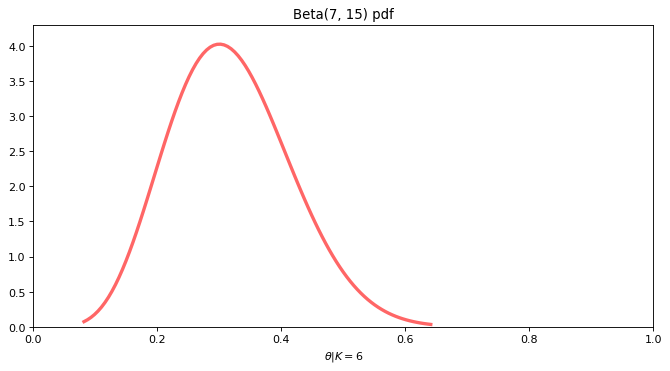

In [5]:
from scipy.stats import uniform, binom, beta
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(beta.ppf(0.001, *posterior_beta_parameters),
                beta.ppf(0.999, *posterior_beta_parameters), 100)
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel(r"$\theta | K = $" + f"{k_obs}")
plt.title(f"Beta{posterior_beta_parameters} pdf")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 4.3)
_ = plt.plot(x, beta.pdf(x, *posterior_beta_parameters), 'r-', lw=3, alpha=0.6)

### A Simple Simulation-Based Derivation of the Posterior

> <i>"We could call Bayesian data analysis 'statistics using conditional probability', but that wouldn’t put the butts in the seats."</i>  
> <p>-- Andrew Gelman</p>

This section illustrates how the beta-binomial posterior density can be derived by simulation.

The approach here is <b>very simple</b> for pedagogical purposes; MCMC is <b>not</b> used.

To do this, we'll work with two lists of $\theta$'s:

* <b><i>priors</i></b>: a list of $m$ independent <i>Uniform(0,1)</i> random numbers

* <b><i>posteriors</i></b>: the subset of priors that, when used in a $Binomial_n(k;\theta)$ trial, result in $k_{obs}$ successes

In [6]:
m = 500_000  # Number of priors

priors = uniform.rvs(size=m)
%time posteriors = [theta for theta in priors if binom.rvs(n, theta)==k_obs]

print(f"\nThere were {len(posteriors)} matches out of {m} priors. (Only {100*len(posteriors)/m:0.2}% matched)")

CPU times: user 17.9 s, sys: 382 ms, total: 18.3 s
Wall time: 17.6 s

There were 23825 matches out of 500000 priors. (Only 4.8% matched)


Below, is a scaled histogram of the values in the posteriors list, overlayed with the beta PDF that was determined above.

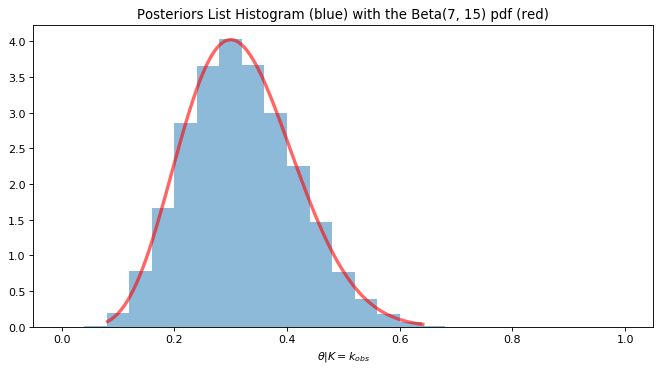

In [7]:
hbins = 25
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel(r"$\theta | K = k_{obs}$")
plt.title(f"Posteriors List Histogram (blue) with the Beta{posterior_beta_parameters} pdf (red)")
plt.plot(x, beta.pdf(x, *posterior_beta_parameters), 'r-', lw=3, alpha=0.6)
_ = plt.hist(posteriors, bins=hbins, density=True, range=[0.0, 1.0], alpha=0.5)

### MCMC-Based Derivation of the Posterior

In [8]:
import pymc3 as pm
import warnings
warnings.simplefilter('ignore')

#### Create the Model

In [9]:
model = pm.Model()

with model:
    theta = pm.Beta("theta", alpha=1, beta=1 )
    k = pm.Binomial("k", p=theta, n=n, observed=k_obs)

model

#### Run the Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6824.13draws/s]


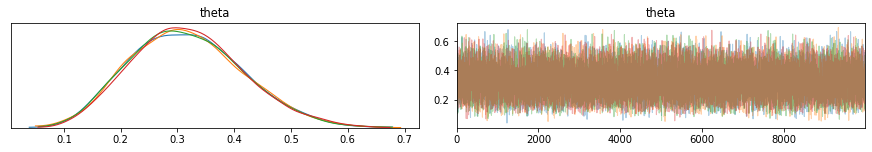

In [10]:
num_samples = 10_000

with model:
    #tr = pm.sample(num_samples, step=pm.Metropolis(), progressbar=True )
    tr = pm.sample(num_samples, progressbar=True )

_ = pm.traceplot(tr)

#### MAP Estimate

The maximum a posteriori (MAP) estimate is for Bayesians what the MLE is for Frequentists.

In [11]:
map_estimate = pm.find_MAP(model=model)
map_estimate['theta']

logp = -3.2978, ||grad|| = 4: 100%|██████████| 6/6 [00:00<00:00, 2892.96it/s]


array(0.29999954)

#### Credible Interval

The <i>credible interval</i> is for Bayesians what the confidence interval is for Frequentists.

The dark horizontal bar in the plot, below, is the highest posterior density (HPD), which is the minimum width credible interval for a specific requested size.

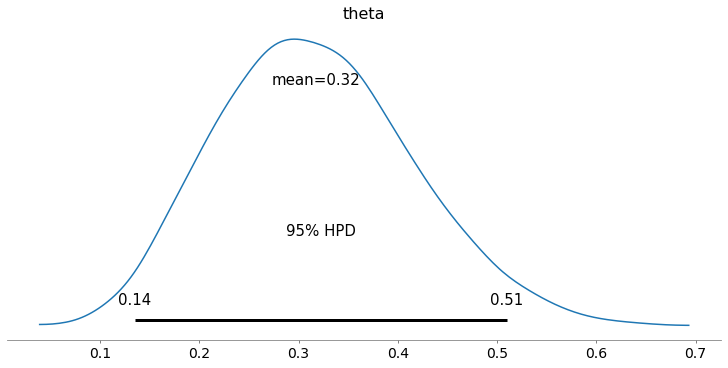

In [12]:
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)
_ = pm.plot_posterior(tr, credible_interval=0.95, ax=axes)

We can compare the HPD, above, with the HPD for the posteriors list calculated using the simple, none-MCMC simulation from earlier:

In [13]:
list(pm.stats.hpd(np.array(posteriors)))

[0.132882035272486, 0.5048875177094144]

#### Plot the MCMC Simulated Data

In [14]:
len(tr['theta'])

40000

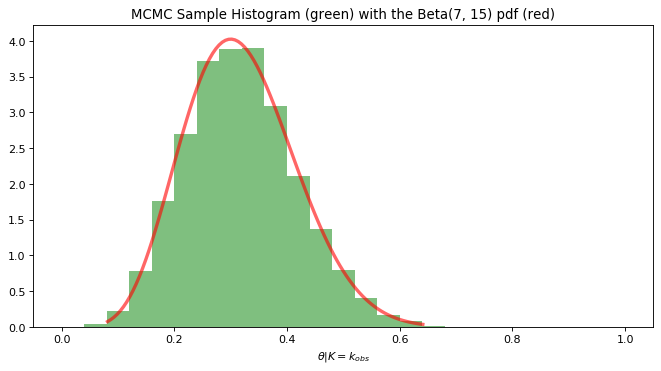

In [15]:
theta_samples = tr['theta', 8000:]

fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel(r"$\theta | K = k_{obs}$")
plt.title(f"MCMC Sample Histogram (green) with the Beta{posterior_beta_parameters} pdf (red)")
plt.plot(x, beta.pdf(x, *posterior_beta_parameters), 'r-', lw=3, alpha=0.6)
_, _, _ = plt.hist(theta_samples, hbins, density=True, range=[0.0, 1.0], alpha=0.5, color='g')

## End of Example

In [16]:
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()